In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng

from scipy.sparse import save_npz, load_npz
from scipy.cluster.hierarchy import dendrogram

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import rbf_kernel

from sklearn.manifold import MDS

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

from gensim.models.phrases import Phraser
from gensim.models import KeyedVectors

import tensorflow as tf

from os.path import expanduser, join

from collections import Counter

import abs_tag_lib as at

# Clustering of papers in the *hep-th* category of the ArXiv

### Goal

In this notebook, we want to get a better understanding of the topics researched in the papers submitted to the *hep-th* category on the arXiv (see the [link](https://arxiv.org/list/hep-th/new)). 

To do so, we use the metadata of all papers uploaded on this category during 2015. In particular, we divide the papers into clusters by considering their title and abstract, so that common topics are identified and used to divide the papers.

Additionally, we use one of our classifiers, trained in a different project ([link](https://github.com/carlosparaciari/abstract-classification-embedding)), to label the papers. We then check the relative frequency of the classes in each cluster, to understand whether the natural splits found in the arXiv category are well-captured by the classifier.

### Methods

We use the arXiv dataset of metadata, available on Kaggle at the following [link](https://www.kaggle.com/Cornell-University/arxiv). We specialize our study to those papers in the *hep-th* category (the theoretical side of High Energy Physics), and in particular to those uploaded in 2015 (the most populous recent year for this category).

We use standard NLP tools to clean the dataset (removing punctuation and LaTex equations, removing stopwords, lemmatizing), and use a TF-IDF vectorizer to map each abstract into a high-dimension vector space. Then, we try to visualize this high-dimensional space by using Multi-Dimensional Scaling, a procedure that aims to embed elements of a $d>3$ vector space into a $d=2$ vector space while preserving the relative distances as measured in the high-dimensional space. 

We then cluster the papers using 3 different methods,

- *K-Means*: using the euclidian distance between the vector representation of the papers, we perform K-Means clustering. To identify the optimal number of clusters, we use the within-point scatter and select K to be the one where an elbow in this metric is visible.

- *Hierarchical clustering*: This technique allows us to build clusters from a bottom-up approach, by merging small clusters into bigger ones. The advantage is that we can use this method to visualize how the different clusters merge, and when, in a dendrogram.

- *Spectral clustering*: This approach is most useful when non-convex clusters are present (which might well not be the case here). The idea is to see the similarity matrix as the adjacency matrix of a graph and to use the eigendecomposition of the graph Laplacian to represent each paper (and perform K-means in this representation).

### Result

Each method provides a similar arrangement of clusters. In particular, a number of clusters between 6 and 8 seem to be optimal according to the within-point scatter computed with K-means. The clusters we find in general seems to be connected with the following topics,

- *gauge theory*
- *cosmology*
- *supersymmetry*
- *black hole physics*
- *AdS-CFT correspondence*
- a more general cluster about *quantum field theories* (that is probably a miscellanea of papers).

We use the centres of the clusters to estimate the topic of the papers, by considering the most important features in each centre. This is possible since we use a vector representation such as TF-IDF.

We finally use a Convolutional Neural Network, trained during a different project with a corpus of HEP papers' metadata released by Springer, to classify the papers. We are interested to see if the classes this model creates reflect the natural structure of the arXiv category under investigation. We find that the CNN has indeed been trained on a relevant dataset since it can classify approx 80% of the papers with a probability higher than 1/2 (out of 8 possible classes). Furthermore, when we consider the relative frequency of the classes in each cluster, we see that in the majority of the clusters (4 out of 6), there is a dominant class, reflecting the fact that the structure of the *hep-th* is captured by the classifier we previously trained.

### Sections

- Obtaining the dataset
- Cleaning abstracts and titles
- Pre-processing title and abstracts
- Data visualization
- Clustering
- Predicting and clustering

## Obtain dataset

Let's first load the metadata archive into a panda dataframe (we can do this in one go since the size of the archive is not unbearable, although we are at the limit). To deal with it otherwise, we would have to stream the json file.

In [2]:
# path to metadata archive
home = expanduser("~")
path_archive = join(home,'Downloads/archive.zip')

# load the archive in pandas dataframe
df = pd.read_json(path_archive,lines=True)

We are here interested in the high energy physics category of the arXiv, especially the theoretical one. We select the items within this category, and the columns we are interested in.

In [3]:
# The category and year we are interested in
category = 'hep-th'
# year = 2015

# The relevant columns for us
relevant_columns = ['id','title','abstract','update_date','authors_parsed']

# Select papers according to category
relevant_items = df['categories'].apply(lambda item : category in item)
df_hep = df[relevant_items][relevant_columns].copy()
df_hep.drop_duplicates(subset='id',inplace=True)

# # Select papers according to year
df_hep['update_date'] = df_hep['update_date'].astype(dtype='datetime64[ns]')
relevant_years = df_hep['update_date'].dt.year == year
df_hep = df_hep[relevant_years]

df_hep.reset_index(drop=True,inplace=True)

# save cleaned dataframe 
df_hep.to_pickle('./dataset/dataset_hep_full.pkl')

In [51]:
len(corpora)

687813

## Cleaning title and abstracts

We are now going to use standard NLP techniques to clean the titles and abstracts.

In [22]:
df_hep = pd.read_pickle('./dataset/dataset_hep.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed
17121,solv-int/9701021,Is the classical Bukhvostov-Lipatov model inte...,"In this work we apply the Weiss, Tabor and C...",2015-06-26,"[[Ameduri, Marco, ], [Efthimiou, Costas J., ]]"
17122,solv-int/9804005,"On the relation between orthogonal, symplectic...",For the unitary ensembles of $N\times N$ Her...,2015-06-26,"[[Widom, Harold, , University of California, S..."
17123,solv-int/9807008,Separation of Variables in the Elliptic Gaudin...,For the elliptic Gaudin model (a degenerate ...,2015-11-13,"[[Sklyanin, Evgueni K., ], [Takebe, Takashi, ]]"
17124,solv-int/9907021,Supersymmetric KP hierarchy in N=1 superspace ...,A wide class of N=2 reductions of the supers...,2015-06-26,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]"
17125,solv-int/9910010,Schlesinger transformations for elliptic isomo...,Schlesinger transformations are discrete mon...,2015-06-26,"[[Korotkin, D., ], [Manojlovic, N., ], [Samtle..."


We are now going to clean the abstracts and titles, that is,
- removing latex equations
- removing punctuation
- setting the words in lowercase
- remove stopwords
- lemmatize the words

In [23]:
# Our choice of lemmatizer and stopwords
wnl = WordNetLemmatizer()
stpw = stopwords.words('english')

# Cleaning the title and abstacts
df_hep['clean_title'] = df_hep['title'].apply(at.clean_text_lemmatize,args=(wnl,stpw))
df_hep['clean_abstract'] = df_hep['abstract'].apply(at.clean_text_lemmatize,args=(wnl,stpw))

Let's check what are the most common words,

In [24]:
words = np.hstack((df_hep['clean_title'],df_hep['clean_abstract']))
words = np.concatenate(words)

full_vocabulary = Counter(words)
full_vocabulary.most_common(10)

[('theory', 20578),
 ('field', 16263),
 ('model', 14170),
 ('non', 8183),
 ('quantum', 8005),
 ('gauge', 7785),
 ('2', 7633),
 ('n', 7539),
 ('space', 7133),
 ('two', 6926)]

And the total number of unique words,

In [25]:
len(full_vocabulary.keys())

20944

We can get rid of non-frequent words in the vocabulary, since they will probably not be useful, and in this way we should reduce the size of the vocabulary (the features, since we will use TF-IDF vectorization later on).

In [36]:
# words with a count higher than min_count are kept in the vocabulary
min_count = 5

vocabulary = [word for word in full_vocabulary.keys() if full_vocabulary[word] > min_count]

The total number of words in the vocabulary is then,

In [37]:
len(vocabulary)

7715

Let's now remove the words that are not in the vocabulary from the title and abstacts,

In [38]:
in_vocabulary_words = lambda item : [word for word in item if word in vocabulary]

df_hep['clean_title'] = df_hep['clean_title'].apply(in_vocabulary_words)
df_hep['clean_abstract'] = df_hep['clean_abstract'].apply(in_vocabulary_words)

We can check if the transformation performed above has empited any of the titles of abstracts, and what is the distributions of lenghts,

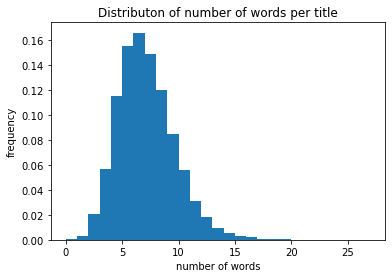

Range for # words in title = 0 - 27


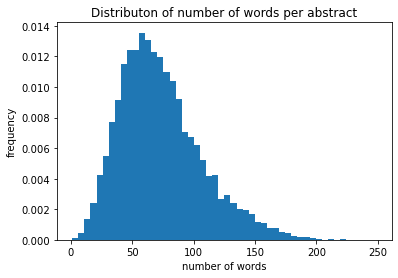

Range for # words in abstract = 1 - 249


In [39]:
title_lengths = df_hep['clean_title'].apply(len).to_numpy()
abstract_lengths = df_hep['clean_abstract'].apply(len).to_numpy()

plt.hist(title_lengths,bins=27,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per title')
plt.show()

print('Range for # words in title = {} - {}'.format(min(title_lengths),
                                                    max(title_lengths)
                                                   )
     )

plt.hist(abstract_lengths,bins=50,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per abstract')
plt.show()

print('Range for # words in abstract = {} - {}'.format(min(abstract_lengths),
                                                       max(abstract_lengths)
                                                      )
     )

We can get rid of those entries with a title with less that 3 words, and an abstract of less than 10 words, I think.

In [40]:
min_count_title = 3
min_count_abstract = 10

bool_keep = np.logical_and(title_lengths>=min_count_title, abstract_lengths>=min_count_abstract)
df_hep = df_hep[bool_keep].reset_index(drop=True)

And finally save the cleaned dataset,

In [41]:
df_hep.to_pickle('./dataset/dataset_hep_cleaned.pkl')

## Pre-processing title and abstracts

We can now pre-process the data. We are going to apply TF-IDF on the joint title and abstract.

In [6]:
df_hep = pd.read_pickle('./dataset/dataset_hep_cleaned.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed,clean_title,clean_abstract
16668,solv-int/9701021,Is the classical Bukhvostov-Lipatov model inte...,"In this work we apply the Weiss, Tabor and C...",2015-06-26,"[[Ameduri, Marco, ], [Efthimiou, Costas J., ]]","[classical, lipatov, model, integrable, painle...","[work, apply, wei, integrability, criterion, p..."
16669,solv-int/9804005,"On the relation between orthogonal, symplectic...",For the unitary ensembles of $N\times N$ Her...,2015-06-26,"[[Widom, Harold, , University of California, S...","[relation, orthogonal, symplectic, unitary, ma...","[unitary, ensemble, hermitian, matrix, associa..."
16670,solv-int/9807008,Separation of Variables in the Elliptic Gaudin...,For the elliptic Gaudin model (a degenerate ...,2015-11-13,"[[Sklyanin, Evgueni K., ], [Takebe, Takashi, ]]","[separation, variable, elliptic, gaudin, model]","[elliptic, gaudin, model, degenerate, case, xy..."
16671,solv-int/9907021,Supersymmetric KP hierarchy in N=1 superspace ...,A wide class of N=2 reductions of the supers...,2015-06-26,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]","[supersymmetric, kp, hierarchy, n, 1, superspa...","[wide, class, n, 2, reduction, supersymmetric,..."
16672,solv-int/9910010,Schlesinger transformations for elliptic isomo...,Schlesinger transformations are discrete mon...,2015-06-26,"[[Korotkin, D., ], [Manojlovic, N., ], [Samtle...","[schlesinger, transformation, elliptic, isomon...","[schlesinger, transformation, discrete, monodr..."


In [43]:
full_corpus = (df_hep['clean_title']+df_hep['clean_abstract']).to_numpy()

# This is needed since we did all the pre-processing outside sklearn
tokens_to_string = np.vectorize(lambda word_list: ' '.join(word_list))

full_corpus = tokens_to_string(full_corpus)

# Let's create the vectorized matrix (while splitting the corpus back into tokens)
vectorizer = TfidfVectorizer(analyzer=str.split)
X = vectorizer.fit_transform(full_corpus)

features = np.array(vectorizer.get_feature_names())

print('The dataset is composed of {} observations and {} features'.format(*X.shape))

The dataset is composed of 16673 observations and 7712 features


In [44]:
save_npz('./dataset/vectorized/X',X)
np.save('./dataset/vectorized/features',features)

## Visualizing the data distribution

Before we start clustering, we'd be interested in checking if the data can indeed be divided into clear clusters. Since checking this in the vectors space we have embedded the features is not possible, we use Multi-Dimensional Scaling (the distance between entries is computed in the high-dimensional vector space, and the items are then represented in 2D while preserving the distance).

Since the number of items we have is too big for computing the similarity matrix and storing it, we sample part of the dataset and use MDS on this subset.

In [2]:
X = load_npz('./dataset/vectorized/X.npz')
features = np.load('./dataset/vectorized/features.npy',allow_pickle=True)

Let's visualize a subset of X randomly sampled,

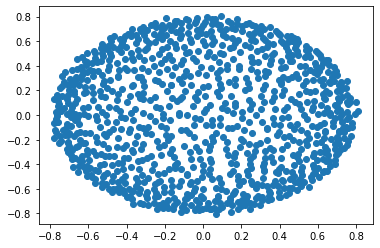

In [21]:
N,_ = X.shape
M = 1000

# Let's sample M items from the dataset, and perform MDS on them
rng = default_rng(seed=8362)
index = rng.choice(N,size=M, replace=False)
sub_X = X[index]

# Let instatiate the multi-dimensional scaling method (we plot the items in 2 dimensions)
mds = MDS(n_components=2,
          n_init=10,
          n_jobs=-1,
          dissimilarity='precomputed'
         )

# We compute the distance between items usign cosine similarity
dist = pairwise_distances(sub_X,metric='cosine',n_jobs=-1)

# We fit the data and represent the items in 2 dimension
sub_X_2D = mds.fit_transform(dist)

# Finally, we plot the items
plt.scatter(*sub_X_2D.T)
plt.show()

From the MDS, it is difficult to see any clusters, really. Other techniques we could use include PCA, but it require the matrix to be dense, and this would be difficult here.

# Clustering

We now use three different techniques to cluster the papers, K-Means, Hierarchical clustering, and Spectral clustering.

## K-means

We start using K-means, which groups observations into K clusters, using their euclidian distance from the centre of the cluster. This algorithm minimize the within-point scatter,

$W(K) = \sum_{k=1}^K \sum_{i,j \in C_k} \| x_i - x_j \|_2$

In what follow, we use the above measure to estimate the optimal number of clusters for the dataset. An heuristic way to do this is to check the curve of whitin-point scatter as the number of clusters increase, and select the optimal number where an elbow can be seen.

Another technique to identify the optimal number of clusters is the gap statistics, but we do not implement it here.

In [25]:
# The max number of clusters and repeated fits to use
M = 20
K = 10

wps_mean = []
wps_std_err = []

for m in range(1,M+1):
    
    wps = []
    
    for _ in range(K):
        
        # Fir K-means with m clusters
        kmeans = KMeans(n_clusters=m)
        kmeans.fit(X)
        
        # Compute the within-point scatter
        wps.append(at.within_point_scatter(X,kmeans.labels_,kmeans.cluster_centers_))

    wps_mean.append(np.mean(wps))
    wps_std_err.append(np.std(wps)/np.sqrt(K))

Let's visualize the within point scatter,

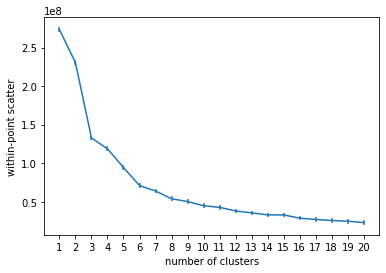

In [14]:
cluster_numbers = np.arange(1,M+1)

plt.errorbar(cluster_numbers,wps_mean,yerr=wps_std_err)
plt.xticks(cluster_numbers)
plt.xlabel('number of clusters')
plt.ylabel('within-point scatter')
plt.show()

Using the elbow rule described above, the optimal number of clusters might be 3, 6, or 8.

### Understanding the clusters

Let's train the model and check the centroids to get a better idea of what the different clusters represent.

In [3]:
m = 6

kmeans= KMeans(n_clusters=m,
               n_init=50,
              )
kmeans.fit(X)

KMeans(n_clusters=6, n_init=50)

We can get an idea of the clusters by looking at the feature importance of the cluster's centres. Since the centres are obtained as a mean of the item inside the cluster, in this way we get the mean feature importance of words over the papers included in the cluster. 

In [62]:
at.feature_importance_cluster(kmeans.cluster_centers_,kmeans.labels_,features)

Cluster 0 - # of items = 376
    - entropy : 0.248
    - entanglement : 0.217
    - holographic : 0.061
    - surface : 0.040
    - state : 0.035
    - theory : 0.034
    - quantum : 0.032
    - field : 0.030
    - renyi : 0.028
    - gravity : 0.028
Cluster 1 - # of items = 1336
    - black : 0.221
    - hole : 0.211
    - horizon : 0.059
    - solution : 0.049
    - entropy : 0.032
    - gravity : 0.030
    - charged : 0.029
    - ad : 0.027
    - scalar : 0.026
    - field : 0.025
Cluster 2 - # of items = 9074
    - field : 0.035
    - theory : 0.034
    - model : 0.029
    - quantum : 0.029
    - gauge : 0.022
    - space : 0.022
    - equation : 0.022
    - function : 0.019
    - gravity : 0.019
    - non : 0.019
Cluster 3 - # of items = 2143
    - inflation : 0.077
    - model : 0.062
    - dark : 0.053
    - scale : 0.052
    - cosmological : 0.046
    - field : 0.042
    - scalar : 0.042
    - universe : 0.040
    - energy : 0.035
    - matter : 0.035
Cluster 4 - # of items = 1

Here we report the results from different choices of K (since K-means randomly initialize the clusters, repeating the above will give slightly different classes).

With 3 clusters, the division of papers is quite uneven,
- 1 big cluster with general quantum field theory papers (~ 10000)
- 1 medium cluster with gauge theories.
- 1 small cluster with black-hole physics/ads-cft correspondence.

With 6 clusters, the division of papers is a bit better, but many papers are still in a big cluster.
- 1 big cluster (~ 7500 papers): general quantum field theory.
- 4 medium clusters (1000-3000 papers): gauge theories, cosmology, supersymmetry, black-hole physics.
- 1 small cluster (~ 400 papers): ads-cft correspondence.

With 8 clusters, we get some specific clusters together with general ones.
- 2 big cluster (~ 5000 papers): general quantum field theory, gauge theory (+more?)
- medium (~1500) : supersymmetry, black-hole physics, cosmology
- small (< 1000): string theory, ads-cft correspondence, Yang-Mills theory (subfield of gauge theory)

### Example of clustered papers

We can check the papers in each clusters to see if they indeed belong to the subfield we predicted from the cluster centre. For example,

In [51]:
# choice of cluster
k = 0

# randomly sample the indices of papers in the cluster
indices_k = np.arange(N)[kmeans.labels_ == k]
index = np.random.choice(indices_k)

# a random example of the paper
print('TITLE : {}'.format(df_hep.iloc[index]['title']))
print('ABS : {}'.format(df_hep.iloc[index]['abstract']))

TITLE : Wormholes and entanglement in holography
ABS :   In this essay, we consider highly entangled states in theories with a gravity
dual, where the entangled degrees of freedom are causally disconnected from
each other. Using the basic rules of holography, we argue that there is a
non-traversable wormhole in the gravity dual whose geometry encodes the pattern
of the entanglement.



## Hierarchical clustering

Hierarchical clustering could be an additional way of making sense of the different subfields in the high energy physics section of the arXiv. With hierarchical clustering, we are aggregating small clusters together to obtain bigger ones, and in this way we can better capture the fact that several small sub-topics can all belong to the same bigger topic, and so on so forth.

There are several metrics one can use to chose which clusters to merge,
- *average* distance between clusters
- *minumum* distance between clusters (the distance between the closest elements in the two clusters)
- *maximum* sistance between clusters (the distance between the farthest elements in the two clusters)
- *Ward* distance, which minimizes the within-cluster variance

In this study, we tryied all these different methods, but we find that Ward distance allow for the creating of clusters of comparable size, while the other techniques, in this case, add an item to a growing cluster iteratively.

In [35]:
hierarchical_cluster = AgglomerativeClustering(n_clusters=None,
                                               distance_threshold=0,
                                               affinity = 'euclidean',
                                               linkage = 'ward'
                                              )
hierarchical_cluster.fit(X.toarray())

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

As a first step, we plot the dendrogram of the hierarchy of clusters here created. Since there are a large number of clusters at the beginning, we only focus on the last part of the dendogram, where big clusters are merged together.

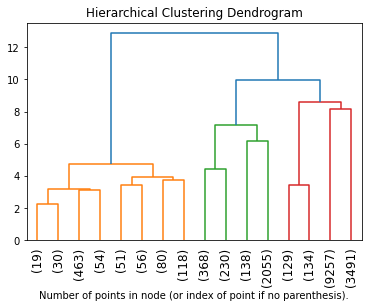

In [47]:
# Compute the linkage matrix to use scipy dendogram for visualizing the clustering
linkage = at.linkage_matrix(hierarchical_cluster)

# Plot the top three levels of the dendrogram
dendrogram(linkage,truncate_mode='level',p=3,distance_sort='ascending',leaf_rotation=90)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

We can see that, even if the model is sucessful in creating clusters of a certain size, most of the items are still collected in a single cluster. One might assume that this is a feature of the dataset we are considering, but K-Means has already demonstrated that smaller clusters can be created that meaningfully divide the dataset.

### Understanding the clusters

Let's train the model to return 8 clusters, and analyse the results by taking the average of the vectorization over the items in each clusters.

In [48]:
m = 8

hc_model = AgglomerativeClustering(n_clusters=m,
                                   affinity = 'euclidean',
                                   linkage = 'ward'
                                  )
hc_model.fit(X.toarray())

AgglomerativeClustering(n_clusters=8)

In [66]:
_,p = X.shape

cluster_centres = []

# Create the average TF-IDF vectors for each clusters
for l in range(hc_model.n_clusters_):
    
    bool_cluster = hc_model.labels_ == l
    
    X_cluster = X[bool_cluster]
    cluster_centres.append(np.mean(X_cluster.toarray(),axis=0))

# Plot the feature importance of the average TF-IDF vector for each cluster
at.feature_importance_cluster(cluster_centres,hc_model.labels_,features)

Cluster 0 - # of items = 2718
    - theory : 0.061
    - n : 0.059
    - gauge : 0.050
    - 2 : 0.048
    - 1 : 0.036
    - spin : 0.034
    - field : 0.034
    - model : 0.032
    - duality : 0.027
    - symmetry : 0.026
Cluster 1 - # of items = 2193
    - model : 0.050
    - dark : 0.043
    - gravity : 0.036
    - cosmological : 0.034
    - field : 0.033
    - theory : 0.033
    - scale : 0.033
    - energy : 0.031
    - matter : 0.031
    - scalar : 0.030
Cluster 2 - # of items = 7971
    - theory : 0.035
    - field : 0.033
    - quantum : 0.031
    - model : 0.029
    - space : 0.021
    - equation : 0.021
    - function : 0.020
    - algebra : 0.019
    - non : 0.019
    - system : 0.018
Cluster 3 - # of items = 598
    - inflation : 0.158
    - model : 0.066
    - field : 0.059
    - scale : 0.054
    - inflaton : 0.053
    - power : 0.050
    - spectrum : 0.046
    - inflationary : 0.045
    - primordial : 0.043
    - scalar : 0.042
Cluster 4 - # of items = 871
    - black : 

The model is able to find similar clusters to those obtained via K-Means. by focusing on 8 clusters, we find that most of the medium-sized one are broken down in more specific ones, while the largest cluster remain quite general.

- small clusters (< 1000): inflation (cosmology), Wilson loops (gauge theory), black holes, ads-cft correspondence
- medium clusters (~ 2000-3000): gauge theory, cosmology
- large cluster (~8000) : quantum field theory

## Spectral Clustering

As a last clustering technique, we use spectral clustering. In this case, we construct a similarity matrix (here we use the radial-basis function kernel to do so), and interpret is as the adjacency matrix of a weighted graph. From this matrix we can compute the Laplacian adn its eigenvalues/eigenvectors,that can be used to cluster the observation using k-Means.

Note that one should first choose how many eigenvectors of the Laplacian to use. To make this choice, we consider the aigenvalues of the Laplacian, and select a reasonable number of the smallest eigenvalues. These eigenvalues are associated with the weakest connection in the graph, and as a result should indicate the presence of different clusters. 

In [3]:
# similarity matrix via radial-basis function kernel
similarity_matrix = rbf_kernel(X, gamma=1.)

# The graph Laplacian used to perform spectral clustering
laplacian = np.diag(np.sum(similarity_matrix,axis=0)) - similarity_matrix

# Eigenvalues of the graph Laplacian
eigvals_laplacian = np.linalg.eigvalsh(laplacian)

Let's visualize the first 400 eigenvalues of the laplacian (but the first one, that is trivially 0),

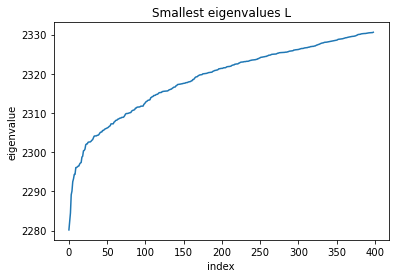

In [7]:
plt.plot(eigvals_laplacian[1:400])
plt.title('Smallest eigenvalues L')
plt.xlabel('index')
plt.ylabel('eigenvalue')
plt.show()

Since the similarity matrix is constructed using a radial-basis kernel, we cannot expect to have multiple components whose nodes are only connected with each others. As a result, only one eigenvalue of the Laplacian is equal to 0, and the others are positive.

The idea is that smaller eigenvalues identify weakly connected components, while bigger eigenvalues identify strongly connected ones. Based on this, we select the first 50 eigenvectors of the Laplacian to perform spectral clustering.

In [9]:
m = 8

spectral_model = SpectralClustering(n_clusters=m,
                                    n_components=50,
                                    affinity='precomputed',
                                    random_state=2763,
                                    assign_labels='kmeans'
                                   )

spectral_model.fit(similarity_matrix)

SpectralClustering(affinity='precomputed', n_components=50, random_state=2763)

In theory, spectral clustering is especially helpful in those situations where the clusters are non-convex. This is not expected to be the case here really, but it is still interesting to see how the model clusters the data.

### Understanding the clusters

To get an idea of the clusters, we still take the average of the TF-IDF vectors of the entries of each clusters. Notice that this is not a good idea if indeed the clusters are non-convex, but I cannot think of another way to get the general features of the clusters otherwise.

In [13]:
_,p = X.shape

cluster_centres = []

# Create the average TF-IDF vectors for each clusters
for l in range(m):
    
    bool_cluster = spectral_model.labels_ == l
    
    X_cluster = X[bool_cluster]
    cluster_centres.append(np.mean(X_cluster.toarray(),axis=0))

# Plot the feature importance of the average TF-IDF vector for each cluster
at.feature_importance_cluster(cluster_centres,spectral_model.labels_,features)

Cluster 0 - # of items = 3123
    - model : 0.090
    - gauge : 0.044
    - theory : 0.043
    - n : 0.031
    - symmetry : 0.030
    - field : 0.029
    - mass : 0.027
    - 2 : 0.026
    - qcd : 0.025
    - yang : 0.025
Cluster 1 - # of items = 2310
    - quantum : 0.083
    - algebra : 0.066
    - operator : 0.054
    - theory : 0.046
    - state : 0.037
    - field : 0.032
    - chern : 0.029
    - simon : 0.029
    - n : 0.027
    - space : 0.024
Cluster 2 - # of items = 442
    - amplitude : 0.237
    - scattering : 0.096
    - loop : 0.092
    - n : 0.058
    - tree : 0.052
    - theory : 0.048
    - level : 0.038
    - 4 : 0.037
    - point : 0.033
    - string : 0.032
Cluster 3 - # of items = 8207
    - theory : 0.039
    - field : 0.034
    - solution : 0.024
    - space : 0.022
    - string : 0.022
    - 2 : 0.021
    - equation : 0.021
    - gravity : 0.021
    - function : 0.021
    - non : 0.019
Cluster 4 - # of items = 341
    - dark : 0.274
    - matter : 0.120
    - en

# Predicting and clustering

We now use one of our pre-trained model for classification to label the different papers based on their abstract. Specifically, we use a Convolutional Neural Network (CNN) trained in a different project (see the [link](https://github.com/carlosparaciari/abstract-classification-embedding) for full details on the model).

We'll then use the clusters created above to see if the classification model is indeed separating the papers into categories that are meaningful for the collection of papers coming from the *hep-th* category on the arXiv.

### Pre-processing the data

As a first step, let's pre-process the abstracts and titles using the embedding which comes with the model (a word2vec embedding we trained on scientific papers coming from the HEP community).

Let's load the NLP tools for identifying common k-grams (k=4 for our model) in HEP literature, and embedding the words into a vector space (here, with dimension = 100).

In [4]:
# Objects for identifying k-grams
bigrams = Phraser.load('./vocabulary/bigrams')
trigrams = Phraser.load('./vocabulary/trigrams')

# Word2vec embedding trained in another project
wv = KeyedVectors.load('./vocabulary/HEPword2vec')

We can load the dataset of HEP papers from the arXiv, which we have studied in the previous part fo the notebook. The goal is to classify these papers, and to do so we need to pre-process the abstracts and titles and embed them into a vector space,

In [5]:
df_hep = pd.read_pickle('./dataset/dataset_hep_cleaned.pkl')

phrases = lambda x : trigrams[bigrams[x]]

# replace k adjacent words with common k-grams
df_hep['clean_title'] = np.array(phrases(df_hep['clean_title']),dtype=object)
df_hep['clean_abstract'] = np.array(phrases(df_hep['clean_abstract']),dtype=object)

We can finally embed each word into the vector space,

In [6]:
embedded_text = at.hashed_padded_sequences(df_hep['clean_title']+df_hep['clean_abstract'],wv)
X_embedded = np.vstack(embedded_text.to_numpy())

### Model prediction

Let's load the model and apply it to the data we processed above,

In [7]:
# CNN trained with TensorFlow
model = tf.keras.models.load_model('./models/cnn_model')

# Labels for the classes
labels = np.load('./models/labels.npy',allow_pickle=True)

# Add unknown class to the list of labels
labels = np.append(labels,'Unknown class')

We can decide to predict by assigning the most likely class to the item, or we can only classify those items with high probability of being in a specific class (otherwise, they will be of an *unknown class*),

In [8]:
#y_predict = labels[np.argmax(model.predict(X_embedded),axis=1)]
y_predict = at.predict_with_treshold(X_embedded, labels, model)

Let's see how the model broadly separates the papers,

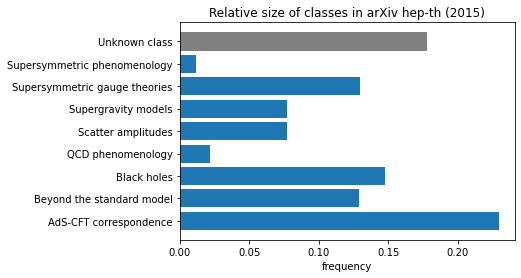

In [14]:
N,_ = X_embedded.shape

class_frequency = Counter(y_predict)
freqs = [class_frequency[l]/N for l in labels]

plot_freqs = plt.barh(range(labels.size), freqs, tick_label=labels)
plot_freqs[-1].set_color('gray')
plt.title('Relative size of classes in arXiv hep-th (2015)')
plt.xlabel('frequency')
plt.show()

From the above plot, we see that,

- The number of papers the algorithm is not able to classify with certainty (prob > 1/2) is ~ 20%.
- The classes falling within phenomenology do not contain many papers. This is not unexpected, since there is an arXiv category called hep-ph and concerning phenomenological models. However, in our training set this distinction was not present.

## Clustering the predictions

We can now see what is the relative proportion of class labels in each cluster. Ideally, it would be good to see the labels being well-separated in different clusters.

Clearly, this might not occur since

- if the clustering model creates less clusters than the classifier, we could have multiple classes with high density in a single cluster.

- The classified has been trained on a different training set, and although the papers in this set were from the HEP community, some of the topics might not appear in the arXiv category *hep-th*.

- Equally, some of the topics in this arXiv category might not have appeard in the training set. If a cluster picks up one of these topics, we could expect the item in such cluster to be randomly classified, or to belong to the *unknown class* label.

Cluster 0 - # of items = 376
    - entropy : 0.248
    - entanglement : 0.216
    - holographic : 0.061
    - surface : 0.041
    - state : 0.035


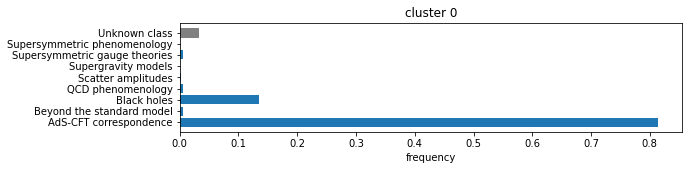

Cluster 1 - # of items = 3447
    - theory : 0.078
    - gauge : 0.065
    - string : 0.060
    - field : 0.045
    - model : 0.029


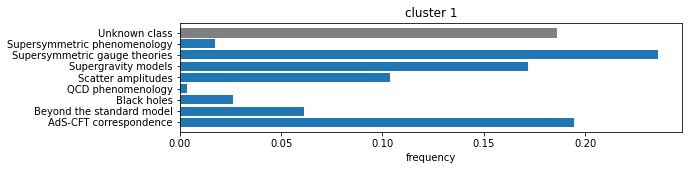

Cluster 2 - # of items = 2193
    - inflation : 0.076
    - model : 0.061
    - dark : 0.052
    - scale : 0.052
    - cosmological : 0.046


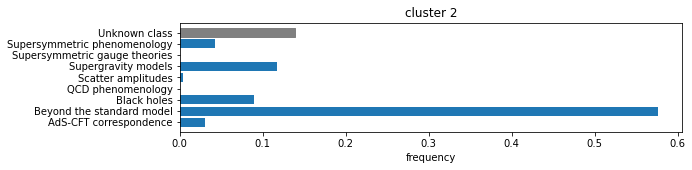

Cluster 3 - # of items = 7559
    - quantum : 0.032
    - model : 0.029
    - field : 0.028
    - equation : 0.023
    - theory : 0.023


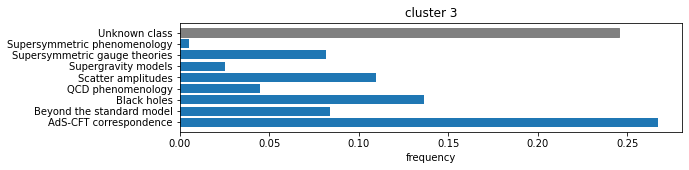

Cluster 4 - # of items = 1348
    - black : 0.221
    - hole : 0.210
    - horizon : 0.059
    - solution : 0.049
    - entropy : 0.032


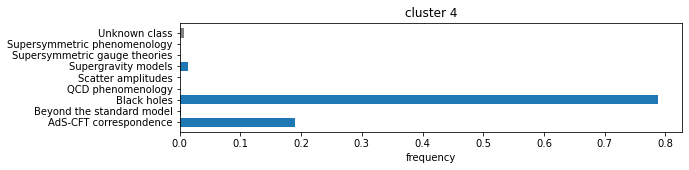

Cluster 5 - # of items = 1750
    - n : 0.148
    - 2 : 0.095
    - 1 : 0.071
    - theory : 0.060
    - 4 : 0.058


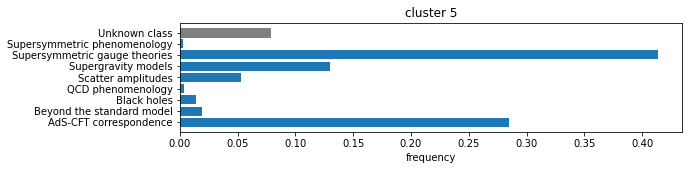

In [15]:
for k in range(kmeans.n_clusters):
    
    # Get items in cluster and their labels
    cluster = kmeans.labels_ == k
    cluster_classes = y_predict[cluster]
    n_cluster = np.sum(cluster)

    # Get the frequency of labels in cluster
    cluster_freq = Counter(cluster_classes)
    width = [cluster_freq[l]/n_cluster for l in labels]

    # Get feature importance of cluster centre
    cluster_centre = kmeans.cluster_centers_[k]
    cluster_features = sorted(zip(features,cluster_centre),
                              key=lambda x: x[1],reverse=True
                             )

    # Print the feature importance in cluster
    n_features = 5
    
    print('Cluster {} - # of items = {}'.format(k,n_cluster))
    for feature, score in cluster_features[:n_features]:
        print('    - {} : {:.3f}'.format(feature, score))

    # Show the plot of label frequency in cluster
    plt.figure(figsize=(9,2))
    plot_cluster = plt.barh(range(labels.size), width,tick_label=labels)
    plot_cluster[-1].set_color('gray')
    plt.title('cluster {}'.format(k))
    plt.xlabel('frequency')
    plt.show()

The labels assigned by the classifier seems to be consistent with some of the clusters identified by K-means. In particular,

- Cluster 0 and 4 deal, respectively, with the *AdS-CFT correpondence* and *black hole physics*. This is confirmed by the most important features for the clusters; for the former, words like 'entropy' and 'holography' are relevant, for the latter, the words 'black hole' and 'hclorizon'.

- Cluster 1 and 5 are a bit mixed, but we can see how the class *Supersymmetric gauge thoeries* is dominant, and indeed words like 'gauge theory' and 'string' are among the most important one.

- Cluster 2 deals with cosmological models and inflation, and the model classify most of the papers with the lable *beyond the std model*.

- Cluster 3 is the big one, without a very well-defined structure, and indeed there is not a specific class associated to it.